# Surrogate-Primed KV Caching Experiment

## Hypothesis
Prepending a domain-specific "surrogate query" to a document before caching will produce KV states that are more receptive to the actual user query, compared to a KV cache built from the document in isolation.

## Experimental Conditions
We compare **four conditions** to isolate the effect of surrogate priming:

| Condition | KV Cache Built From | Purpose |
|-----------|---------------------|---------|
| **Pure Baseline** | Document only | Cache with zero framing |
| **Framed Baseline** | "Document:\n" + Document | Cache with structure but no query |
| **Surrogate-Primed** | Query frame + Surrogate + Document | Cache "directed" toward anticipated queries |
| **Oracle** | Query frame + Ground Truth Query + Document | Upper bound (perfect surrogate) |

## Metric
We measure **Conditional Perplexity Delta**:
- `Delta = NLL(Query | Baseline Cache) - NLL(Query | Surrogate Cache)`
- **Positive Delta** = Surrogate reduced surprise (success)
- **Negative Delta** = Surrogate confused the model (failure)

## Additional Analysis
- **Surrogate Quality**: Semantic similarity between generated surrogate and ground truth query
- **Oracle Gap**: How far the surrogate is from a perfect surrogate (ground truth)
- **Failure Mode Analysis**: Categorization of why surrogates fail

## Step 1: Configuration & Setup

In [22]:
# Install dependencies if needed
!pip install transformers torch datasets tqdm scipy bitsandbytes accelerate matplotlib sentence-transformers

In [23]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import json
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# For surrogate quality measurement
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
@dataclass
class ExperimentConfig:
    """Configuration for the Surrogate-Primed KV Caching experiment."""
    
    # Model settings
    model_name: str = "mistralai/Mistral-7B-Instruct-v0.2"
    
    # Quantization for memory efficiency (fits on T4/L4 GPU)
    use_4bit: bool = True
    
    # Dataset settings
    dataset_name: str = "ms_marco"
    dataset_config: str = "v1.1"
    dataset_split: str = "validation"
    num_samples: int = 100
    min_passage_words: int = 50
    max_passage_words: int = 200
    
    # Surrogate generation settings
    surrogate_temperature: float = 0.0  # Deterministic for reproducibility
    surrogate_max_tokens: int = 30  # Increased from 15 to avoid truncation
    
    # Prompts for three-condition design
    # Condition A: Pure document (no framing at all)
    baseline_prompt_pure: str = ""
    
    # Condition B: Framed document (has structure, but no query)
    baseline_prompt_framed: str = "Document:\n"
    
    # Condition C: Surrogate-primed (query + document)
    surrogate_prefix_template: str = "Query: {surrogate}\n\nDocument:\n"
    
    # Improved surrogate generation prompt (more explicit instructions)
    surrogate_generation_prompt: str = (
        "Read the following text and write ONE short search query (3-8 words) "
        "that someone would type into Google to find this text. "
        "Output only the query with no quotes, alternatives, or explanation."
    )
    
    # Embedding model for surrogate quality measurement
    embedding_model_name: str = "all-MiniLM-L6-v2"
    
    # Random seed for reproducibility
    seed: int = 42
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


config = ExperimentConfig()
print(f"Running on device: {config.device}")
print(f"Model: {config.model_name}")
print(f"4-bit quantization: {config.use_4bit}")

Running on device: cuda
Model: mistralai/Mistral-7B-Instruct-v0.2
4-bit quantization: True


In [25]:
# Set random seeds for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Load model and tokenizer
print("Loading model and tokenizer...")

if config.use_4bit:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        quantization_config=quantization_config,
        device_map="auto",
        trust_remote_code=True,
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
    )

tokenizer = AutoTokenizer.from_pretrained(config.model_name, trust_remote_code=True)

# Ensure padding is on the right (critical for causal LM)
tokenizer.padding_side = "right"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model.eval()
print(f"Model loaded successfully. Parameters: {model.num_parameters():,}")

# Load embedding model for surrogate quality measurement
print(f"\nLoading embedding model: {config.embedding_model_name}")
embed_model = SentenceTransformer(config.embedding_model_name)
print("Embedding model loaded successfully.")

Loading model and tokenizer...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded successfully. Parameters: 7,241,732,096

Loading embedding model: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded successfully.


## Step 2: Dataset Loading & Filtering

In [26]:
def count_words(text: str) -> int:
    """Count words in a text string."""
    return len(text.split())


def load_and_filter_dataset(config: ExperimentConfig) -> List[Dict]:
    """
    Load MS MARCO dataset and filter passages by word count.
    
    Returns list of dicts with 'passage' and 'query' keys.
    """
    print(f"Loading {config.dataset_name} dataset...")
    
    # Load MS MARCO
    dataset = load_dataset(
        config.dataset_name,
        config.dataset_config,
        split=config.dataset_split,
        trust_remote_code=True
    )
    
    print(f"Total samples in {config.dataset_split}: {len(dataset)}")
    
    # Filter and extract valid samples
    filtered_samples = []
    
    for item in tqdm(dataset, desc="Filtering passages"):
        # MS MARCO has passages as a list; we take the first relevant one
        passages = item.get('passages', {})
        passage_texts = passages.get('passage_text', [])
        is_selected = passages.get('is_selected', [])
        
        query = item.get('query', '')
        
        if not passage_texts or not query:
            continue
        
        # Find a passage that meets word count criteria
        for i, passage in enumerate(passage_texts):
            word_count = count_words(passage)
            if config.min_passage_words <= word_count <= config.max_passage_words:
                # Prefer selected passages if available
                if is_selected and i < len(is_selected) and is_selected[i] == 1:
                    filtered_samples.append({
                        'passage': passage,
                        'query': query
                    })
                    break
                elif not any(is_selected):  # No selection info, take first valid
                    filtered_samples.append({
                        'passage': passage,
                        'query': query
                    })
                    break
        
        # Early stop if we have enough
        if len(filtered_samples) >= config.num_samples * 2:  # Buffer for random selection
            break
    
    # Randomly sample the required number
    np.random.shuffle(filtered_samples)
    filtered_samples = filtered_samples[:config.num_samples]
    
    print(f"Selected {len(filtered_samples)} samples meeting criteria")
    return filtered_samples

In [27]:
# Load and filter dataset
samples = load_and_filter_dataset(config)

# Preview a sample
print("\n" + "="*80)
print("SAMPLE PREVIEW")
print("="*80)
print(f"\nPassage ({count_words(samples[0]['passage'])} words):")
print(samples[0]['passage'][:500] + "..." if len(samples[0]['passage']) > 500 else samples[0]['passage'])
print(f"\nGround Truth Query: {samples[0]['query']}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'ms_marco' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading ms_marco dataset...
Total samples in validation: 10047


Filtering passages:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 100 samples meeting criteria

SAMPLE PREVIEW

Passage (50 words):
Patient Comments Read 22 Comments Share Your Story. Fifth disease is a mild illness caused by a virus called human parvovirus B19. The medical name for fifth disease is erythema infectiosum (EI). This infection occurs primarily in school-age children between 5 and 14 years of age during winter and spring.

Ground Truth Query: what age of children fifths disease


## Step 3: Surrogate Query Generator

This function generates a "surrogate query" from a document. The surrogate mimics what a user might search for to find this document. 

**Critical**: The generator NEVER sees the ground truth query - it only sees the document (mimicking "indexing time").

**Improvements**:
- Increased max tokens (30) to avoid truncation
- Explicit prompt to generate ONE query with no alternatives or quotes
- Quality measurement via semantic similarity to ground truth

In [28]:
def generate_surrogate(
    doc_text: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> str:
    """
    Generate a surrogate query for a document.
    
    The surrogate is what we hypothesize a user might search to find this document.
    This function uses the model's chat template for proper instruction following.
    
    Args:
        doc_text: The document/passage text
        model: The language model
        tokenizer: The tokenizer
        config: Experiment configuration
    
    Returns:
        Generated surrogate query string
    """
    # Build the prompt using chat template for instruct models
    messages = [
        {
            "role": "user",
            "content": f"{config.surrogate_generation_prompt}\n\nText:\n{doc_text}"
        }
    ]
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to(config.device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=config.surrogate_max_tokens,
            temperature=config.surrogate_temperature if config.surrogate_temperature > 0 else None,
            do_sample=config.surrogate_temperature > 0,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    # Decode only the generated tokens (exclude prompt)
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    surrogate = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    
    # Clean up common artifacts
    # Remove quotes if present
    surrogate = surrogate.strip('"\'')
    # Take only first line if multiple
    surrogate = surrogate.split('\n')[0].strip()
    
    return surrogate


def compute_surrogate_similarity(
    surrogate: str, 
    ground_truth: str, 
    embed_model: SentenceTransformer
) -> float:
    """
    Compute semantic similarity between surrogate and ground truth query.
    
    Args:
        surrogate: Generated surrogate query
        ground_truth: Ground truth query from dataset
        embed_model: Sentence transformer model for embeddings
    
    Returns:
        Cosine similarity score (0-1, higher = more similar)
    """
    embeddings = embed_model.encode([surrogate, ground_truth])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return float(similarity)

In [29]:
# Test surrogate generation and similarity
print("Testing surrogate generation...")
test_surrogate = generate_surrogate(samples[0]['passage'], model, tokenizer, config)
test_similarity = compute_surrogate_similarity(test_surrogate, samples[0]['query'], embed_model)

print(f"\nDocument preview: {samples[0]['passage'][:200]}...")
print(f"\nGenerated Surrogate: '{test_surrogate}'")
print(f"Ground Truth Query: '{samples[0]['query']}'")
print(f"Semantic Similarity: {test_similarity:.4f}")

Testing surrogate generation...

Document preview: Patient Comments Read 22 Comments Share Your Story. Fifth disease is a mild illness caused by a virus called human parvovirus B19. The medical name for fifth disease is erythema infectiosum (EI). This...

Generated Surrogate: 'fifth disease symptoms and comments'
Ground Truth Query: 'what age of children fifths disease'
Semantic Similarity: 0.6617


## Step 4: Scoring Engine - KV Cache Surgery

This is the critical component. We perform "KV Cache Surgery":

1. **Prefill Phase**: Forward pass the context (prompt + document) to generate the KV cache
2. **Decode Phase**: Forward pass the target query using the frozen KV cache
3. **Scoring**: Compute NLL only on the target query tokens

### Mathematical Foundation

For a sequence `[context, target]`, the model computes:
- Keys: `K = W_k @ [context, target]`  
- Values: `V = W_v @ [context, target]`

The KV cache stores `K_context` and `V_context` from the prefill. During decoding, attention is computed as:

```
Attention(Q_target, [K_context; K_target], [V_context; V_target])
```

By priming with different contexts, we change `K_context` and `V_context`, potentially making them more "receptive" to `Q_target`.

In [30]:
def compute_conditional_nll(
    context_prefix: str,
    document: str,
    target_query: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> Tuple[float, int]:
    """
    Compute the Negative Log-Likelihood of target_query conditioned on
    the KV cache generated from (context_prefix + document).
    
    This implements "KV Cache Surgery":
    1. Prefill: Generate KV cache from context
    2. Decode: Score target using the frozen cache
    3. Loss: Compute NLL only on target tokens
    
    Args:
        context_prefix: The prefix prompt (baseline or surrogate-based)
        document: The document/passage text
        target_query: The ground truth query to score
        model: The language model
        tokenizer: The tokenizer
        config: Experiment configuration
    
    Returns:
        Tuple of (nll_value, num_target_tokens)
    """
    # =========================================================================
    # STEP 1: Tokenize context and target separately
    # =========================================================================
    # Build full context string
    context_str = context_prefix + document
    
    # Tokenize context (no padding - we process one sample at a time)
    context_encoding = tokenizer(
        context_str,
        return_tensors="pt",
        add_special_tokens=True,  # Add BOS if model uses it
        padding=False,
        truncation=False
    )
    context_ids = context_encoding['input_ids'].to(config.device)
    context_len = context_ids.shape[1]
    
    # Tokenize target (no special tokens - it continues from context)
    target_encoding = tokenizer(
        target_query,
        return_tensors="pt",
        add_special_tokens=False,  # No BOS - continues from context
        padding=False,
        truncation=False
    )
    target_ids = target_encoding['input_ids'].to(config.device)
    target_len = target_ids.shape[1]
    
    # =========================================================================
    # STEP 2: Prefill - Generate KV cache from context
    # =========================================================================
    # Forward pass through context to build KV cache
    # We don't need the logits from this pass, only the cache
    with torch.no_grad():
        prefill_outputs = model(
            input_ids=context_ids,
            attention_mask=torch.ones_like(context_ids),
            use_cache=True,
            return_dict=True
        )
        
        # Extract the KV cache
        # Shape per layer: (batch, num_heads, seq_len, head_dim)
        past_key_values = prefill_outputs.past_key_values
    
    # =========================================================================
    # STEP 3: Decode - Forward pass target with frozen KV cache
    # =========================================================================
    # CRITICAL: The attention mask must cover BOTH context AND target
    # The model needs to know the full sequence length for position embeddings
    # and attention masking
    combined_len = context_len + target_len
    attention_mask = torch.ones((1, combined_len), device=config.device)
    
    # Forward pass target tokens using the cached KV states
    with torch.no_grad():
        decode_outputs = model(
            input_ids=target_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            use_cache=False,  # Don't need to extend cache further
            return_dict=True
        )
    
    # =========================================================================
    # STEP 4: Compute NLL on target tokens only
    # =========================================================================
    # decode_outputs.logits shape: (batch, target_len, vocab_size)
    # For autoregressive loss, we predict token[i+1] from logits[i]
    # So we use logits[:-1] to predict target_ids[1:]
    
    logits = decode_outputs.logits  # (1, target_len, vocab_size)
    
    # Shift: predict next token from current position
    # logits[:, :-1, :] predicts target_ids[:, 1:]
    shift_logits = logits[:, :-1, :].contiguous()  # (1, target_len-1, vocab)
    shift_labels = target_ids[:, 1:].contiguous()  # (1, target_len-1)
    
    # Flatten for cross entropy
    shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    shift_labels = shift_labels.view(-1)
    
    # Compute per-token cross entropy (NLL)
    loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
    nll = loss_fct(shift_logits, shift_labels).item()
    
    # Number of tokens scored (target_len - 1 due to shift)
    num_scored_tokens = target_len - 1
    
    # Return mean NLL per token for comparability
    mean_nll = nll / num_scored_tokens if num_scored_tokens > 0 else 0.0
    
    return mean_nll, num_scored_tokens

In [31]:
# Test the scoring engine with all conditions
print("Testing scoring engine with all conditions...")

test_sample = samples[0]

# Condition A: Pure baseline (document only)
pure_nll, pure_tokens = compute_conditional_nll(
    context_prefix=config.baseline_prompt_pure,
    document=test_sample['passage'],
    target_query=test_sample['query'],
    model=model,
    tokenizer=tokenizer,
    config=config
)

# Condition B: Framed baseline
framed_nll, framed_tokens = compute_conditional_nll(
    context_prefix=config.baseline_prompt_framed,
    document=test_sample['passage'],
    target_query=test_sample['query'],
    model=model,
    tokenizer=tokenizer,
    config=config
)

# Condition C: Surrogate-primed
surrogate = generate_surrogate(test_sample['passage'], model, tokenizer, config)
surrogate_prefix = config.surrogate_prefix_template.format(surrogate=surrogate)

surrogate_nll, surrogate_tokens = compute_conditional_nll(
    context_prefix=surrogate_prefix,
    document=test_sample['passage'],
    target_query=test_sample['query'],
    model=model,
    tokenizer=tokenizer,
    config=config
)

# Condition D: Oracle (ground truth query as surrogate)
oracle_prefix = config.surrogate_prefix_template.format(surrogate=test_sample['query'])
oracle_nll, oracle_tokens = compute_conditional_nll(
    context_prefix=oracle_prefix,
    document=test_sample['passage'],
    target_query=test_sample['query'],
    model=model,
    tokenizer=tokenizer,
    config=config
)

# Compute deltas
delta_vs_pure = pure_nll - surrogate_nll
delta_vs_framed = framed_nll - surrogate_nll
oracle_gap = surrogate_nll - oracle_nll

print(f"\n{'='*60}")
print("CONDITION COMPARISON")
print(f"{'='*60}")
print(f"Pure Baseline NLL:    {pure_nll:.4f} ({pure_tokens} tokens)")
print(f"Framed Baseline NLL:  {framed_nll:.4f} ({framed_tokens} tokens)")
print(f"Surrogate NLL:        {surrogate_nll:.4f} ({surrogate_tokens} tokens)")
print(f"Oracle NLL:           {oracle_nll:.4f} ({oracle_tokens} tokens)")
print(f"\n{'='*60}")
print("DELTAS (positive = surrogate better)")
print(f"{'='*60}")
print(f"Delta vs Pure:   {delta_vs_pure:.4f} {'✓' if delta_vs_pure > 0 else '✗'}")
print(f"Delta vs Framed: {delta_vs_framed:.4f} {'✓' if delta_vs_framed > 0 else '✗'}")
print(f"Oracle Gap:      {oracle_gap:.4f} (how far from perfect)")

Testing scoring engine with all conditions...

CONDITION COMPARISON
Pure Baseline NLL:    4.1042 (6 tokens)
Framed Baseline NLL:  3.8750 (6 tokens)
Surrogate NLL:        5.2708 (6 tokens)
Oracle NLL:           0.1979 (6 tokens)

DELTAS (positive = surrogate better)
Delta vs Pure:   -1.1667 ✗
Delta vs Framed: -1.3958 ✗
Oracle Gap:      5.0729 (how far from perfect)


## Step 5: Main Experiment Loop

In [32]:
def run_experiment(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig
) -> List[Dict]:
    """
    Run the full experiment comparing all conditions for KV caching.
    
    Conditions:
    - Pure baseline: Document only (no framing)
    - Framed baseline: "Document:\n" + document
    - Surrogate-primed: Query frame + surrogate + document
    - Oracle: Query frame + ground truth query + document
    
    Args:
        samples: List of {passage, query} dicts
        model: The language model
        tokenizer: The tokenizer
        embed_model: Sentence transformer for similarity measurement
        config: Experiment configuration
    
    Returns:
        List of result dicts with NLLs, deltas, and quality metrics
    """
    results = []
    
    for i, sample in enumerate(tqdm(samples, desc="Running experiment")):
        passage = sample['passage']
        query = sample['query']
        
        try:
            # Generate surrogate query (only sees document, NOT ground truth query)
            surrogate = generate_surrogate(passage, model, tokenizer, config)
            
            # Compute surrogate quality (semantic similarity to ground truth)
            surrogate_similarity = compute_surrogate_similarity(surrogate, query, embed_model)
            
            # Condition A: Pure baseline (document only)
            pure_nll, num_tokens = compute_conditional_nll(
                context_prefix=config.baseline_prompt_pure,
                document=passage,
                target_query=query,
                model=model,
                tokenizer=tokenizer,
                config=config
            )
            
            # Condition B: Framed baseline
            framed_nll, _ = compute_conditional_nll(
                context_prefix=config.baseline_prompt_framed,
                document=passage,
                target_query=query,
                model=model,
                tokenizer=tokenizer,
                config=config
            )
            
            # Condition C: Surrogate-primed
            surrogate_prefix = config.surrogate_prefix_template.format(surrogate=surrogate)
            surrogate_nll, _ = compute_conditional_nll(
                context_prefix=surrogate_prefix,
                document=passage,
                target_query=query,
                model=model,
                tokenizer=tokenizer,
                config=config
            )
            
            # Condition D: Oracle (ground truth query as surrogate)
            oracle_prefix = config.surrogate_prefix_template.format(surrogate=query)
            oracle_nll, _ = compute_conditional_nll(
                context_prefix=oracle_prefix,
                document=passage,
                target_query=query,
                model=model,
                tokenizer=tokenizer,
                config=config
            )
            
            # Compute all deltas (positive = surrogate better)
            delta_vs_pure = pure_nll - surrogate_nll
            delta_vs_framed = framed_nll - surrogate_nll
            oracle_gap = surrogate_nll - oracle_nll
            
            results.append({
                'sample_idx': i,
                'query': query,
                'surrogate': surrogate,
                'surrogate_similarity': surrogate_similarity,
                # NLL values for all conditions
                'pure_nll': pure_nll,
                'framed_nll': framed_nll,
                'surrogate_nll': surrogate_nll,
                'oracle_nll': oracle_nll,
                # Delta comparisons
                'delta_vs_pure': delta_vs_pure,
                'delta_vs_framed': delta_vs_framed,
                'oracle_gap': oracle_gap,
                # Metadata
                'num_tokens': num_tokens,
                'passage_preview': passage[:100] + '...' if len(passage) > 100 else passage
            })
            
        except Exception as e:
            print(f"\nError processing sample {i}: {e}")
            continue
        
        # Clear GPU cache periodically
        if i % 20 == 0:
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return results

In [33]:
# Run the experiment
print(f"Running experiment on {len(samples)} samples...")
print("="*80)

results = run_experiment(samples, model, tokenizer, embed_model, config)

print(f"\nCompleted {len(results)} samples successfully")

Running experiment on 100 samples...


Running experiment:   0%|          | 0/100 [00:00<?, ?it/s]


Completed 100 samples successfully


## Step 6: Analysis & Visualization

In [34]:
def analyze_results(results: List[Dict]) -> Dict:
    """
    Compute summary statistics and perform statistical tests for all conditions.
    
    Args:
        results: List of result dicts from experiment
    
    Returns:
        Dictionary of analysis results
    """
    # Extract arrays
    pure_nlls = np.array([r['pure_nll'] for r in results])
    framed_nlls = np.array([r['framed_nll'] for r in results])
    surrogate_nlls = np.array([r['surrogate_nll'] for r in results])
    oracle_nlls = np.array([r['oracle_nll'] for r in results])
    similarities = np.array([r['surrogate_similarity'] for r in results])
    
    deltas_vs_pure = np.array([r['delta_vs_pure'] for r in results])
    deltas_vs_framed = np.array([r['delta_vs_framed'] for r in results])
    oracle_gaps = np.array([r['oracle_gap'] for r in results])
    
    # Win rates (surrogate beats baseline)
    wins_vs_pure = np.sum(deltas_vs_pure > 0)
    wins_vs_framed = np.sum(deltas_vs_framed > 0)
    
    # Statistical tests: Surrogate vs Pure
    t_stat_pure, p_value_pure = stats.ttest_rel(pure_nlls, surrogate_nlls)
    wilcoxon_stat_pure, wilcoxon_p_pure = stats.wilcoxon(pure_nlls, surrogate_nlls, alternative='two-sided')
    
    # Statistical tests: Surrogate vs Framed
    t_stat_framed, p_value_framed = stats.ttest_rel(framed_nlls, surrogate_nlls)
    wilcoxon_stat_framed, wilcoxon_p_framed = stats.wilcoxon(framed_nlls, surrogate_nlls, alternative='two-sided')
    
    # Effect sizes (Cohen's d)
    diff_pure = pure_nlls - surrogate_nlls
    cohens_d_pure = np.mean(diff_pure) / np.std(diff_pure, ddof=1) if np.std(diff_pure) > 0 else 0
    
    diff_framed = framed_nlls - surrogate_nlls
    cohens_d_framed = np.mean(diff_framed) / np.std(diff_framed, ddof=1) if np.std(diff_framed) > 0 else 0
    
    # Correlation: Does surrogate quality predict success?
    corr_similarity_delta_pure, corr_p_pure = stats.pearsonr(similarities, deltas_vs_pure)
    corr_similarity_delta_framed, corr_p_framed = stats.pearsonr(similarities, deltas_vs_framed)
    
    analysis = {
        'n_samples': len(results),
        
        # NLL means for all conditions
        'mean_pure_nll': np.mean(pure_nlls),
        'mean_framed_nll': np.mean(framed_nlls),
        'mean_surrogate_nll': np.mean(surrogate_nlls),
        'mean_oracle_nll': np.mean(oracle_nlls),
        
        # NLL standard deviations
        'std_pure_nll': np.std(pure_nlls),
        'std_framed_nll': np.std(framed_nlls),
        'std_surrogate_nll': np.std(surrogate_nlls),
        'std_oracle_nll': np.std(oracle_nlls),
        
        # Win/loss vs pure baseline
        'wins_vs_pure': int(wins_vs_pure),
        'win_rate_vs_pure': wins_vs_pure / len(results),
        'mean_delta_vs_pure': np.mean(deltas_vs_pure),
        'std_delta_vs_pure': np.std(deltas_vs_pure),
        'median_delta_vs_pure': np.median(deltas_vs_pure),
        
        # Win/loss vs framed baseline
        'wins_vs_framed': int(wins_vs_framed),
        'win_rate_vs_framed': wins_vs_framed / len(results),
        'mean_delta_vs_framed': np.mean(deltas_vs_framed),
        'std_delta_vs_framed': np.std(deltas_vs_framed),
        'median_delta_vs_framed': np.median(deltas_vs_framed),
        
        # Oracle gap statistics
        'mean_oracle_gap': np.mean(oracle_gaps),
        'std_oracle_gap': np.std(oracle_gaps),
        
        # Statistical tests vs pure
        't_statistic_vs_pure': t_stat_pure,
        'p_value_vs_pure': p_value_pure,
        'cohens_d_vs_pure': cohens_d_pure,
        'wilcoxon_p_vs_pure': wilcoxon_p_pure,
        
        # Statistical tests vs framed
        't_statistic_vs_framed': t_stat_framed,
        'p_value_vs_framed': p_value_framed,
        'cohens_d_vs_framed': cohens_d_framed,
        'wilcoxon_p_vs_framed': wilcoxon_p_framed,
        
        # Surrogate quality analysis
        'mean_surrogate_similarity': np.mean(similarities),
        'std_surrogate_similarity': np.std(similarities),
        'corr_similarity_delta_pure': corr_similarity_delta_pure,
        'corr_p_similarity_pure': corr_p_pure,
        'corr_similarity_delta_framed': corr_similarity_delta_framed,
        'corr_p_similarity_framed': corr_p_framed,
    }
    
    return analysis


def analyze_failure_modes(results: List[Dict]) -> Dict[str, List[Dict]]:
    """
    Categorize why surrogate priming fails.
    
    Args:
        results: List of result dicts from experiment
    
    Returns:
        Dictionary mapping failure category to list of failed samples
    """
    # Failures where surrogate did worse than framed baseline
    failures = [r for r in results if r['delta_vs_framed'] < 0]
    
    categories = {
        'truncated_surrogate': [],      # Surrogate appears cut off
        'multi_option_surrogate': [],   # Contains "or" alternatives  
        'low_similarity': [],           # Surrogate very different from query
        'high_oracle_gap': [],          # Large gap from oracle performance
        'other': [],                    # Uncategorized failures
    }
    
    for r in failures:
        surrogate = r['surrogate']
        categorized = False
        
        # Check for truncation indicators
        if surrogate.endswith('...') or surrogate.endswith('…') or len(surrogate.split()) < 3:
            categories['truncated_surrogate'].append(r)
            categorized = True
        
        # Check for multiple options
        if ' or ' in surrogate.lower() or '"' in surrogate:
            categories['multi_option_surrogate'].append(r)
            categorized = True
        
        # Check for low similarity
        if r.get('surrogate_similarity', 1.0) < 0.3:
            categories['low_similarity'].append(r)
            categorized = True
        
        # Check for high oracle gap (surrogate much worse than oracle)
        if r.get('oracle_gap', 0) > 1.0:
            categories['high_oracle_gap'].append(r)
            categorized = True
        
        if not categorized:
            categories['other'].append(r)
    
    return categories, len(failures)

In [35]:
# Compute analysis
analysis = analyze_results(results)
failure_categories, total_failures = analyze_failure_modes(results)

# Print comprehensive summary
print("="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)
print(f"\nSamples analyzed: {analysis['n_samples']}")

print(f"\n{'='*80}")
print("NLL BY CONDITION (lower is better)")
print(f"{'='*80}")
print(f"{'Condition':<20} {'Mean NLL':>12} {'Std':>10}")
print(f"{'-'*42}")
print(f"{'Pure Baseline':<20} {analysis['mean_pure_nll']:>12.4f} {analysis['std_pure_nll']:>10.4f}")
print(f"{'Framed Baseline':<20} {analysis['mean_framed_nll']:>12.4f} {analysis['std_framed_nll']:>10.4f}")
print(f"{'Surrogate-Primed':<20} {analysis['mean_surrogate_nll']:>12.4f} {analysis['std_surrogate_nll']:>10.4f}")
print(f"{'Oracle (upper bound)':<20} {analysis['mean_oracle_nll']:>12.4f} {analysis['std_oracle_nll']:>10.4f}")

print(f"\n{'='*80}")
print("SURROGATE VS PURE BASELINE")
print(f"{'='*80}")
print(f"Win Rate:     {analysis['wins_vs_pure']}/{analysis['n_samples']} ({analysis['win_rate_vs_pure']*100:.1f}%)")
print(f"Mean Delta:   {analysis['mean_delta_vs_pure']:.4f} (positive = surrogate better)")
print(f"Median Delta: {analysis['median_delta_vs_pure']:.4f}")
print(f"t-test:       t={analysis['t_statistic_vs_pure']:.4f}, p={analysis['p_value_vs_pure']:.6f}")
print(f"Wilcoxon:     p={analysis['wilcoxon_p_vs_pure']:.6f}")
print(f"Cohen's d:    {analysis['cohens_d_vs_pure']:.4f}")

print(f"\n{'='*80}")
print("SURROGATE VS FRAMED BASELINE")
print(f"{'='*80}")
print(f"Win Rate:     {analysis['wins_vs_framed']}/{analysis['n_samples']} ({analysis['win_rate_vs_framed']*100:.1f}%)")
print(f"Mean Delta:   {analysis['mean_delta_vs_framed']:.4f} (positive = surrogate better)")
print(f"Median Delta: {analysis['median_delta_vs_framed']:.4f}")
print(f"t-test:       t={analysis['t_statistic_vs_framed']:.4f}, p={analysis['p_value_vs_framed']:.6f}")
print(f"Wilcoxon:     p={analysis['wilcoxon_p_vs_framed']:.6f}")
print(f"Cohen's d:    {analysis['cohens_d_vs_framed']:.4f}")

print(f"\n{'='*80}")
print("ORACLE GAP ANALYSIS")
print(f"{'='*80}")
print(f"Mean Oracle Gap:    {analysis['mean_oracle_gap']:.4f} (surrogate NLL - oracle NLL)")
print(f"Std Oracle Gap:     {analysis['std_oracle_gap']:.4f}")
print("(Smaller gap = surrogate closer to perfect)")

print(f"\n{'='*80}")
print("SURROGATE QUALITY ANALYSIS")
print(f"{'='*80}")
print(f"Mean Semantic Similarity: {analysis['mean_surrogate_similarity']:.4f}")
print(f"Std Semantic Similarity:  {analysis['std_surrogate_similarity']:.4f}")
print(f"\nCorrelation: Similarity vs Delta (Pure)")
print(f"  r={analysis['corr_similarity_delta_pure']:.4f}, p={analysis['corr_p_similarity_pure']:.6f}")
print(f"Correlation: Similarity vs Delta (Framed)")
print(f"  r={analysis['corr_similarity_delta_framed']:.4f}, p={analysis['corr_p_similarity_framed']:.6f}")

print(f"\n{'='*80}")
print("FAILURE MODE ANALYSIS")
print(f"{'='*80}")
print(f"Total failures (surrogate worse than framed): {total_failures}")
for cat, items in failure_categories.items():
    if items:
        print(f"  {cat}: {len(items)} ({len(items)/total_failures*100:.1f}% of failures)")

# Final conclusion
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
significance_level = 0.05

if analysis['p_value_vs_pure'] < significance_level:
    if analysis['mean_delta_vs_pure'] > 0:
        print("vs Pure Baseline: Surrogate SIGNIFICANTLY BETTER")
    else:
        print("vs Pure Baseline: Surrogate SIGNIFICANTLY WORSE")
else:
    print("vs Pure Baseline: No significant difference")

if analysis['p_value_vs_framed'] < significance_level:
    if analysis['mean_delta_vs_framed'] > 0:
        print("vs Framed Baseline: Surrogate SIGNIFICANTLY BETTER")
    else:
        print("vs Framed Baseline: Surrogate SIGNIFICANTLY WORSE")
else:
    print("vs Framed Baseline: No significant difference")

EXPERIMENT RESULTS SUMMARY

Samples analyzed: 100

NLL BY CONDITION (lower is better)
Condition                Mean NLL        Std
------------------------------------------
Pure Baseline              2.0718     1.5318
Framed Baseline            2.1855     1.4792
Surrogate-Primed           2.4925     1.5485
Oracle (upper bound)       0.3790     0.6037

SURROGATE VS PURE BASELINE
Win Rate:     16/100 (16.0%)
Mean Delta:   -0.4207 (positive = surrogate better)
Median Delta: -0.3882
t-test:       t=-6.5636, p=0.000000
Wilcoxon:     p=0.000000
Cohen's d:    -0.6564

SURROGATE VS FRAMED BASELINE
Win Rate:     25/100 (25.0%)
Mean Delta:   -0.3070 (positive = surrogate better)
Median Delta: -0.2539
t-test:       t=-5.8709, p=0.000000
Wilcoxon:     p=0.000000
Cohen's d:    -0.5871

ORACLE GAP ANALYSIS
Mean Oracle Gap:    2.1136 (surrogate NLL - oracle NLL)
Std Oracle Gap:     1.3639
(Smaller gap = surrogate closer to perfect)

SURROGATE QUALITY ANALYSIS
Mean Semantic Similarity: 0.6612
Std Sem

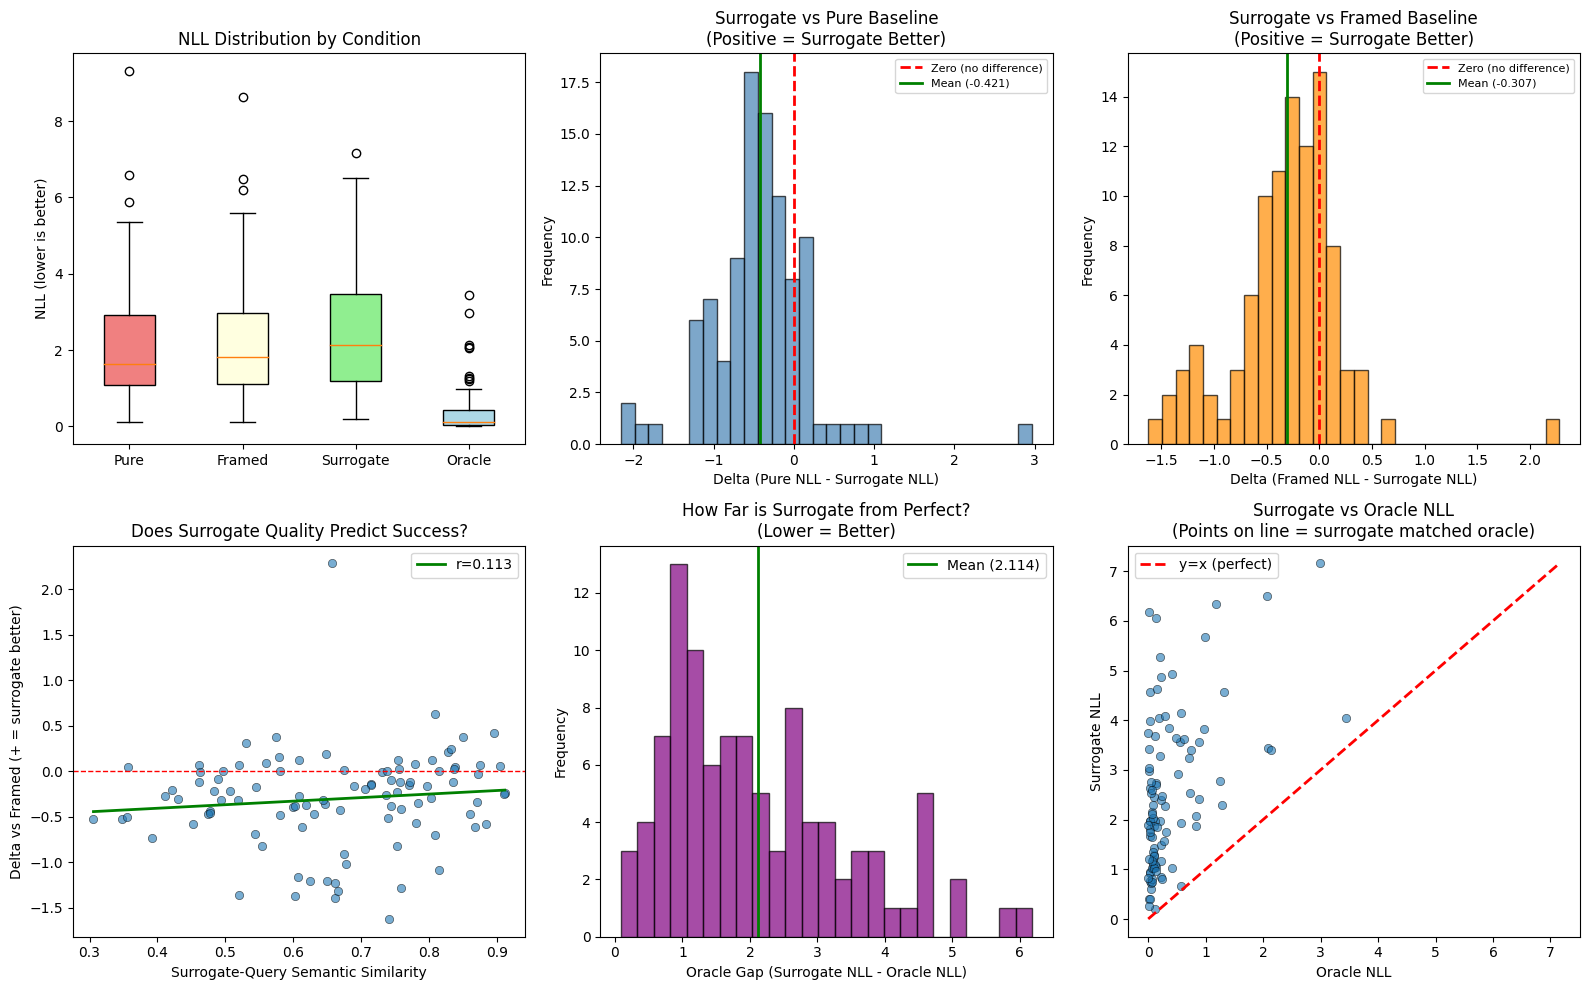


Figure saved to: experiment_results_extended.png


In [36]:
# Extended Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Extract data
pure_nlls = [r['pure_nll'] for r in results]
framed_nlls = [r['framed_nll'] for r in results]
surrogate_nlls = [r['surrogate_nll'] for r in results]
oracle_nlls = [r['oracle_nll'] for r in results]
similarities = [r['surrogate_similarity'] for r in results]
deltas_vs_pure = [r['delta_vs_pure'] for r in results]
deltas_vs_framed = [r['delta_vs_framed'] for r in results]
oracle_gaps = [r['oracle_gap'] for r in results]

# Plot 1: Box plot of all conditions
ax1 = axes[0, 0]
box_data = [pure_nlls, framed_nlls, surrogate_nlls, oracle_nlls]
bp = ax1.boxplot(box_data, labels=['Pure', 'Framed', 'Surrogate', 'Oracle'], patch_artist=True)
colors = ['lightcoral', 'lightyellow', 'lightgreen', 'lightblue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('NLL (lower is better)')
ax1.set_title('NLL Distribution by Condition')

# Plot 2: Histogram of Delta vs Pure
ax2 = axes[0, 1]
ax2.hist(deltas_vs_pure, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (no difference)')
ax2.axvline(x=np.mean(deltas_vs_pure), color='green', linestyle='-', linewidth=2, 
            label=f'Mean ({np.mean(deltas_vs_pure):.3f})')
ax2.set_xlabel('Delta (Pure NLL - Surrogate NLL)')
ax2.set_ylabel('Frequency')
ax2.set_title('Surrogate vs Pure Baseline\n(Positive = Surrogate Better)')
ax2.legend(fontsize=8)

# Plot 3: Histogram of Delta vs Framed
ax3 = axes[0, 2]
ax3.hist(deltas_vs_framed, bins=30, edgecolor='black', alpha=0.7, color='darkorange')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (no difference)')
ax3.axvline(x=np.mean(deltas_vs_framed), color='green', linestyle='-', linewidth=2,
            label=f'Mean ({np.mean(deltas_vs_framed):.3f})')
ax3.set_xlabel('Delta (Framed NLL - Surrogate NLL)')
ax3.set_ylabel('Frequency')
ax3.set_title('Surrogate vs Framed Baseline\n(Positive = Surrogate Better)')
ax3.legend(fontsize=8)

# Plot 4: Surrogate similarity vs Delta (does quality predict success?)
ax4 = axes[1, 0]
ax4.scatter(similarities, deltas_vs_framed, alpha=0.6, edgecolor='black', linewidth=0.5)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=1)
# Add trend line
z = np.polyfit(similarities, deltas_vs_framed, 1)
p = np.poly1d(z)
x_line = np.linspace(min(similarities), max(similarities), 100)
ax4.plot(x_line, p(x_line), 'g-', linewidth=2, 
         label=f'r={analysis["corr_similarity_delta_framed"]:.3f}')
ax4.set_xlabel('Surrogate-Query Semantic Similarity')
ax4.set_ylabel('Delta vs Framed (+ = surrogate better)')
ax4.set_title('Does Surrogate Quality Predict Success?')
ax4.legend()

# Plot 5: Oracle gap distribution
ax5 = axes[1, 1]
ax5.hist(oracle_gaps, bins=25, edgecolor='black', alpha=0.7, color='purple')
ax5.axvline(x=np.mean(oracle_gaps), color='green', linestyle='-', linewidth=2,
            label=f'Mean ({np.mean(oracle_gaps):.3f})')
ax5.set_xlabel('Oracle Gap (Surrogate NLL - Oracle NLL)')
ax5.set_ylabel('Frequency')
ax5.set_title('How Far is Surrogate from Perfect?\n(Lower = Better)')
ax5.legend()

# Plot 6: Surrogate vs Oracle scatter
ax6 = axes[1, 2]
ax6.scatter(oracle_nlls, surrogate_nlls, alpha=0.6, edgecolor='black', linewidth=0.5)
min_val = min(min(oracle_nlls), min(surrogate_nlls))
max_val = max(max(oracle_nlls), max(surrogate_nlls))
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (perfect)')
ax6.set_xlabel('Oracle NLL')
ax6.set_ylabel('Surrogate NLL')
ax6.set_title('Surrogate vs Oracle NLL\n(Points on line = surrogate matched oracle)')
ax6.legend()

plt.tight_layout()
plt.savefig('experiment_results_extended.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to: experiment_results_extended.png")

In [37]:
# Show examples: Best and worst cases (relative to framed baseline)
sorted_results = sorted(results, key=lambda x: x['delta_vs_framed'], reverse=True)

print("="*80)
print("TOP 5 SURROGATE WINS (vs Framed Baseline)")
print("="*80)
for r in sorted_results[:5]:
    print(f"\nDelta vs Framed: {r['delta_vs_framed']:.4f} | Similarity: {r['surrogate_similarity']:.4f}")
    print(f"  Ground Truth Query: {r['query']}")
    print(f"  Generated Surrogate: {r['surrogate']}")
    print(f"  NLLs: Pure={r['pure_nll']:.3f} | Framed={r['framed_nll']:.3f} | Surrogate={r['surrogate_nll']:.3f} | Oracle={r['oracle_nll']:.3f}")

print("\n" + "="*80)
print("TOP 5 BASELINE WINS (vs Framed Baseline)")
print("="*80)
for r in sorted_results[-5:]:
    print(f"\nDelta vs Framed: {r['delta_vs_framed']:.4f} | Similarity: {r['surrogate_similarity']:.4f}")
    print(f"  Ground Truth Query: {r['query']}")
    print(f"  Generated Surrogate: {r['surrogate']}")
    print(f"  NLLs: Pure={r['pure_nll']:.3f} | Framed={r['framed_nll']:.3f} | Surrogate={r['surrogate_nll']:.3f} | Oracle={r['oracle_nll']:.3f}")

# Also show high-similarity samples to see if quality helps
print("\n" + "="*80)
print("HIGHEST SIMILARITY SURROGATES (top 5)")
print("="*80)
sorted_by_similarity = sorted(results, key=lambda x: x['surrogate_similarity'], reverse=True)
for r in sorted_by_similarity[:5]:
    print(f"\nSimilarity: {r['surrogate_similarity']:.4f} | Delta vs Framed: {r['delta_vs_framed']:.4f}")
    print(f"  Ground Truth Query: {r['query']}")
    print(f"  Generated Surrogate: {r['surrogate']}")

TOP 5 SURROGATE WINS (vs Framed Baseline)

Delta vs Framed: 2.2812 | Similarity: 0.6575
  Ground Truth Query: determines meaning
  Generated Surrogate: define determine meaning examples
  NLLs: Pure=9.312 | Framed=8.625 | Surrogate=6.344 | Oracle=1.188

Delta vs Framed: 0.6250 | Similarity: 0.8093
  Ground Truth Query: salary of import and export in usa
  Generated Surrogate: entry-level import/export salaries us
  NLLs: Pure=2.732 | Framed=4.196 | Surrogate=3.571 | Oracle=0.884

Delta vs Framed: 0.4187 | Similarity: 0.8962
  Ground Truth Query: how much does a social worker make in florida
  Generated Surrogate: average social worker salary florida 2010
  NLLs: Pure=0.372 | Framed=0.819 | Surrogate=0.400 | Oracle=0.016

Delta vs Framed: 0.3750 | Similarity: 0.5751
  Ground Truth Query: how much do ladies footballers get paid
  Generated Surrogate: annual football player earnings
  NLLs: Pure=2.357 | Framed=3.107 | Surrogate=2.732 | Oracle=0.136

Delta vs Framed: 0.3687 | Similarity: 0

## Step 7: Save Results

In [ ]:
# Save detailed results
output_data = {
    'config': {
        'model_name': config.model_name,
        'num_samples': config.num_samples,
        'baseline_prompt_pure': config.baseline_prompt_pure,
        'baseline_prompt_framed': config.baseline_prompt_framed,
        'surrogate_prefix_template': config.surrogate_prefix_template,
        'surrogate_generation_prompt': config.surrogate_generation_prompt,
        'surrogate_max_tokens': config.surrogate_max_tokens,
        'embedding_model_name': config.embedding_model_name,
        'seed': config.seed,
    },
    'analysis': analysis,
    'failure_analysis': {
        'total_failures': total_failures,
        'categories': {k: len(v) for k, v in failure_categories.items()}
    },
    'results': results
}

with open('experiment_results.json', 'w') as f:
    json.dump(output_data, f, indent=2, default=str)

print("Results saved to: experiment_results.json")

## Appendix: Ablation Studies

### A. Different Surrogate Prefix Templates
Test how the framing of the surrogate affects performance.

### B. Different Surrogate Generation Strategies  
Instead of generating a search query, try:
- **Summary**: One-sentence summary of the document
- **Keywords**: Key terms from the document
- **Question**: A question the document answers

In [ ]:
def generate_with_custom_prompt(
    doc_text: str,
    generation_prompt: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> str:
    """
    Generate a surrogate using a custom generation prompt.
    """
    messages = [
        {
            "role": "user",
            "content": f"{generation_prompt}\n\nText:\n{doc_text}"
        }
    ]
    
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    inputs = tokenizer(prompt, return_tensors="pt").to(config.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=config.surrogate_max_tokens,
            temperature=config.surrogate_temperature if config.surrogate_temperature > 0 else None,
            do_sample=config.surrogate_temperature > 0,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    result = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    result = result.strip('"\'').split('\n')[0].strip()
    
    return result


def run_ablation_prefix_templates(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig,
    prefix_variants: Dict[str, str],
    num_ablation_samples: int = 20
) -> Dict[str, Dict]:
    """
    Run ablation study with different surrogate prefix templates.
    """
    ablation_results = {}
    ablation_samples = samples[:num_ablation_samples]
    
    for variant_name, template in prefix_variants.items():
        print(f"\nRunning prefix ablation: {variant_name}")
        
        variant_results = []
        for sample in tqdm(ablation_samples, desc=f"  {variant_name}"):
            try:
                surrogate = generate_surrogate(sample['passage'], model, tokenizer, config)
                surrogate_prefix = template.format(surrogate=surrogate)
                
                framed_nll, _ = compute_conditional_nll(
                    context_prefix=config.baseline_prompt_framed,
                    document=sample['passage'],
                    target_query=sample['query'],
                    model=model, tokenizer=tokenizer, config=config
                )
                
                surrogate_nll, _ = compute_conditional_nll(
                    context_prefix=surrogate_prefix,
                    document=sample['passage'],
                    target_query=sample['query'],
                    model=model, tokenizer=tokenizer, config=config
                )
                
                variant_results.append({
                    'delta_vs_framed': framed_nll - surrogate_nll
                })
            except Exception as e:
                continue
        
        deltas = [r['delta_vs_framed'] for r in variant_results]
        ablation_results[variant_name] = {
            'template': template,
            'win_rate': np.mean([d > 0 for d in deltas]),
            'mean_delta': np.mean(deltas),
            'std_delta': np.std(deltas),
            'n_samples': len(deltas)
        }
    
    return ablation_results


def run_ablation_generation_strategies(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig,
    generation_prompts: Dict[str, str],
    num_ablation_samples: int = 20
) -> Dict[str, Dict]:
    """
    Run ablation study with different surrogate generation strategies.
    """
    ablation_results = {}
    ablation_samples = samples[:num_ablation_samples]
    
    for strategy_name, gen_prompt in generation_prompts.items():
        print(f"\nRunning generation strategy ablation: {strategy_name}")
        
        variant_results = []
        for sample in tqdm(ablation_samples, desc=f"  {strategy_name}"):
            try:
                # Generate surrogate with custom prompt
                surrogate = generate_with_custom_prompt(
                    sample['passage'], gen_prompt, model, tokenizer, config
                )
                
                similarity = compute_surrogate_similarity(surrogate, sample['query'], embed_model)
                
                surrogate_prefix = config.surrogate_prefix_template.format(surrogate=surrogate)
                
                framed_nll, _ = compute_conditional_nll(
                    context_prefix=config.baseline_prompt_framed,
                    document=sample['passage'],
                    target_query=sample['query'],
                    model=model, tokenizer=tokenizer, config=config
                )
                
                surrogate_nll, _ = compute_conditional_nll(
                    context_prefix=surrogate_prefix,
                    document=sample['passage'],
                    target_query=sample['query'],
                    model=model, tokenizer=tokenizer, config=config
                )
                
                variant_results.append({
                    'surrogate': surrogate,
                    'similarity': similarity,
                    'delta_vs_framed': framed_nll - surrogate_nll
                })
            except Exception as e:
                continue
        
        deltas = [r['delta_vs_framed'] for r in variant_results]
        similarities = [r['similarity'] for r in variant_results]
        
        ablation_results[strategy_name] = {
            'generation_prompt': gen_prompt[:50] + '...',
            'win_rate': np.mean([d > 0 for d in deltas]),
            'mean_delta': np.mean(deltas),
            'std_delta': np.std(deltas),
            'mean_similarity': np.mean(similarities),
            'n_samples': len(deltas),
            'example_surrogates': [r['surrogate'] for r in variant_results[:3]]
        }
    
    return ablation_results

In [ ]:
# Ablation A: Different prefix templates
print("="*80)
print("ABLATION A: PREFIX TEMPLATE VARIANTS")
print("="*80)

prefix_variants = {
    'query_focused': "Query: {surrogate}\n\nDocument:\n",
    'question_focused': "Question: {surrogate}\n\nText:\n",
    'search_focused': "User searched for: {surrogate}\n\nResult:\n",
    'minimal': "{surrogate}\n\n",
    'instruction': "Answer this query using the document below.\nQuery: {surrogate}\n\nDocument:\n",
}

prefix_ablation_results = run_ablation_prefix_templates(
    samples, model, tokenizer, embed_model, config, prefix_variants
)

print("\n" + "-"*60)
print("PREFIX TEMPLATE ABLATION RESULTS")
print("-"*60)
print(f"{'Template':<20} {'Win Rate':>10} {'Mean Delta':>12} {'Std':>10}")
print("-"*52)
for name, data in sorted(prefix_ablation_results.items(), key=lambda x: x[1]['mean_delta'], reverse=True):
    print(f"{name:<20} {data['win_rate']*100:>9.1f}% {data['mean_delta']:>12.4f} {data['std_delta']:>10.4f}")


# Ablation B: Different generation strategies
print("\n" + "="*80)
print("ABLATION B: GENERATION STRATEGY VARIANTS")
print("="*80)

generation_strategies = {
    'query': (
        "Read the following text and write ONE short search query (3-8 words) "
        "that someone would type into Google to find this text. "
        "Output only the query with no quotes, alternatives, or explanation."
    ),
    'summary': (
        "Summarize the following text in ONE short sentence (under 15 words). "
        "Output only the summary, nothing else."
    ),
    'keywords': (
        "Extract 3-5 key terms or phrases from the following text. "
        "Output only the keywords separated by commas, nothing else."
    ),
    'question': (
        "Write ONE question (5-10 words) that the following text answers. "
        "Output only the question with no extra text."
    ),
}

strategy_ablation_results = run_ablation_generation_strategies(
    samples, model, tokenizer, embed_model, config, generation_strategies
)

print("\n" + "-"*60)
print("GENERATION STRATEGY ABLATION RESULTS")
print("-"*60)
print(f"{'Strategy':<12} {'Win Rate':>10} {'Mean Delta':>12} {'Similarity':>12}")
print("-"*48)
for name, data in sorted(strategy_ablation_results.items(), key=lambda x: x[1]['mean_delta'], reverse=True):
    print(f"{name:<12} {data['win_rate']*100:>9.1f}% {data['mean_delta']:>12.4f} {data['mean_similarity']:>12.4f}")

print("\nExample surrogates by strategy:")
for name, data in strategy_ablation_results.items():
    print(f"\n{name}:")
    for i, ex in enumerate(data['example_surrogates'][:2]):
        print(f"  {i+1}. {ex[:60]}{'...' if len(ex) > 60 else ''}")

---

## Notes on Interpretation

### Experimental Design

This experiment tests whether pre-conditioning a KV cache with a surrogate query improves the model's ability to predict actual user queries, compared to a KV cache built from the document in isolation.

**Four conditions tested:**
1. **Pure Baseline**: Document only (no framing) - represents cache built in complete isolation
2. **Framed Baseline**: "Document:\n" + Document - adds minimal structure
3. **Surrogate-Primed**: Query frame + generated surrogate + Document
4. **Oracle**: Query frame + ground truth query + Document (upper bound)

### Interpreting Results

**If Surrogate beats Pure/Framed baselines:**
- Surrogate priming successfully "steers" the KV cache toward the query space
- The document embeddings become more aligned with typical query patterns

**If Surrogate loses to baselines:**
- The generic cache may already provide sufficient context
- Surrogate generation quality may be a bottleneck
- The surrogate may be introducing noise/misdirection

**Oracle Gap Analysis:**
- Small oracle gap: Surrogate is close to optimal
- Large oracle gap: Surrogate quality is the limiting factor
- Correlation between similarity and delta: Quality predicts success

### Potential Confounds

1. **Length effects**: Different prefix lengths affect position embeddings
2. **Surrogate quality varies**: Some passages produce better surrogates
3. **Query specificity**: Ground truth queries may use terms not inferrable from document

### Key Metrics

- **Win Rate**: % of samples where surrogate beats baseline
- **Mean Delta**: Average improvement (positive = surrogate better)
- **Cohen's d**: Effect size (|d| > 0.2 = small, > 0.5 = medium, > 0.8 = large)
- **Similarity-Delta Correlation**: Whether better surrogates lead to better results